## Clustering Mixed data of a Heart Failure Clinical Record Dataset

### 1. Importing and Exploring the Data

In [29]:
import warnings
import pandas as pd
import numpy as np

# ignore all warnings
warnings. filterwarnings("ignore")

# read data into dataframe variable df
df = pd.read_csv("/Users/vanshtyagi/Desktop/Bennett/heart_failure_clinical_records_dataset.csv")
print('Size of heart failure clinical dataframe is :', df.shape)

# display first few rows of data
df.head()

Size of heart failure clinical dataframe is : (299, 13)


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [30]:
df.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

### 2. Data Preprocessing 

In [31]:
# select columns to cluster

cluster_columns = ['age', 'sex', 'serum_sodium', 'platelets', 'smoking']

df = df[cluster_columns]

In [33]:
from sklearn.preprocessing import StandardScaler

# define numerical and categorical columns
numerical_columns = ['age', 'serum_sodium', 'platelets']
categorical_columns = ['sex', 'smoking']

scaler = StandardScaler()

# create a copy of our data to be scaled
df_scale = df.copy()
# standard scale numerical features
for c in numerical_columns:
    df_scale[c] = scaler.fit_transform(df[[c]])

In [34]:
df_scale.head()

,age,sex,serum_sodium,platelets,smoking
0,1.192945,1,-1.504036,1.681648e-02,0
1,-0.491279,1,-0.141976,7.535660e-09,0
2,0.350833,1,-1.731046,-1.038073e+00,1
3,-0.912335,1,0.085034,-5.464741e-01,0
4,0.350833,0,-4.682176,6.517986e-01,0


In [35]:
df_out = df_scale[(df_scale['age'].abs()<=3) & (df_scale['platelets'].abs()<=3) & (df_scale['serum_sodium'].abs()<=3)]
df_out.shape

(293, 5)

### 3. Finding Optimal Number of Clusters

It is important that we look at various cluster evaluation metrics to get suggestions of how many clusters we could cluster our data into.

For this section we are going to be looking at 2 cluster evaluation metrics:
*  Elbow Method
* Average Silhouette Method

In order to use these cluster evaluation methods, we have to apply K-protoypes clustering on our data for various number of clusters. For this we are required to feed the indexes of the categorical columns of our data.

In [36]:
from kmodes.kprototypes import KPrototypes

categorical_indexes = []

for c in categorical_columns:
    categorical_indexes.append(df.columns.get_loc(c))

categorical_indexes

[1, 4]

#### The Elbow Method

Matplotlib is building the font cache; this may take a moment.


Text(0, 0.5, 'Cost')

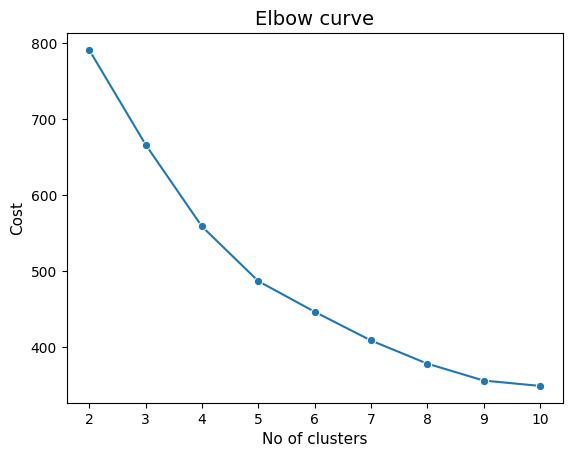

In [37]:
import seaborn as sns

num_clusters = list(range(2, 11))

cost_values = []

# calculate cost values for each number of clusters (2 to 10)
for k in num_clusters:
    kproto = KPrototypes(n_clusters=k, init='Huang', random_state=42)
    kproto.fit_predict(df_scale, categorical= categorical_indexes)
    cost_values.append(kproto.cost_)

# plot cost against number of clusters
ax = sns.lineplot(x=num_clusters, y=cost_values, marker="o")
ax.set_title('Elbow curve', fontsize=14)
ax.set_xlabel('No of clusters', fontsize=11)
ax.set_ylabel('Cost', fontsize=11)

#### The Average Silhouette Method

Text(0, 0.5, 'score')

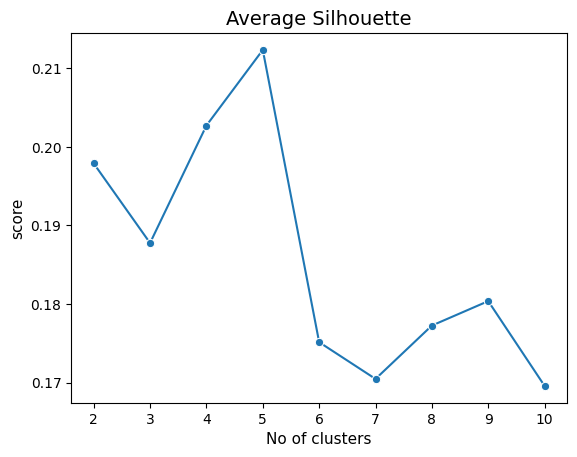

In [38]:
from sklearn.metrics import silhouette_score

silhouette_avg = []

# calculate average silhouette score for each number of cluster (2 to 10)
for k in num_clusters:
    kproto = KPrototypes(n_clusters=k, init='Huang', random_state=42)
    kproto.fit_predict(df_scale, categorical= categorical_indexes)
    cluster_labels = kproto.labels_
    silhouette_avg.append(silhouette_score(df_scale, cluster_labels))

# plot average silhouette score against number of clusters
ax = sns.lineplot(x=num_clusters, y=silhouette_avg, marker="o")
ax.set_title('Average Silhouette', fontsize=14)
ax.set_xlabel('No of clusters', fontsize=11)
ax.set_ylabel('score', fontsize=11)

From the above two plots we note that **5** clusters seems reasonable for our data. We note that the cluster quality is quite poor with a **low** silhouette score. 

### 4. Clustering the Data

In [39]:
# we set the number of clusters to 5
kproto = KPrototypes(n_clusters= 5, init='Huang', n_init = 25, random_state=42)
kproto.fit_predict(df_scale, categorical= categorical_indexes)

# store cluster labels
cluster_labels = kproto.labels_

# add clusters to dataframe
df["cluster"] = cluster_labels

# check if clusters have been added to the dataframe
df.head()

,age,sex,serum_sodium,platelets,smoking,cluster
0,75.0,1,130,265000.00,0,0
1,55.0,1,136,263358.03,0,3
2,65.0,1,129,162000.00,1,1
3,50.0,1,137,210000.00,0,3
4,65.0,0,116,327000.00,0,1


### 5. Cluster Exploration

In order to visualise our clusters we can make use of a dimension reduction algorithm called principle component analysis (PCA).

In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_df = pca.fit_transform(df_scale)

In [57]:
import plotly.graph_objects as go
import plotly.io as pio

# Set a compatible renderer
pio.renderers.default = "browser"  # Try "browser" or "png" if notebook still fails

# Your plotting code
fig = go.Figure(
    go.Scatter3d(
        mode='markers',
        x=pca_df[:, 0],
        y=pca_df[:, 1],
        z=pca_df[:, 2],
        marker=dict(size=5, color=df['cluster'], colorscale='spectral')
    )
)
fig.show()


In [42]:
# size of each cluster

df["cluster"].value_counts()

cluster
3    100
0     80
2     56
4     37
1     26
Name: count, dtype: int64

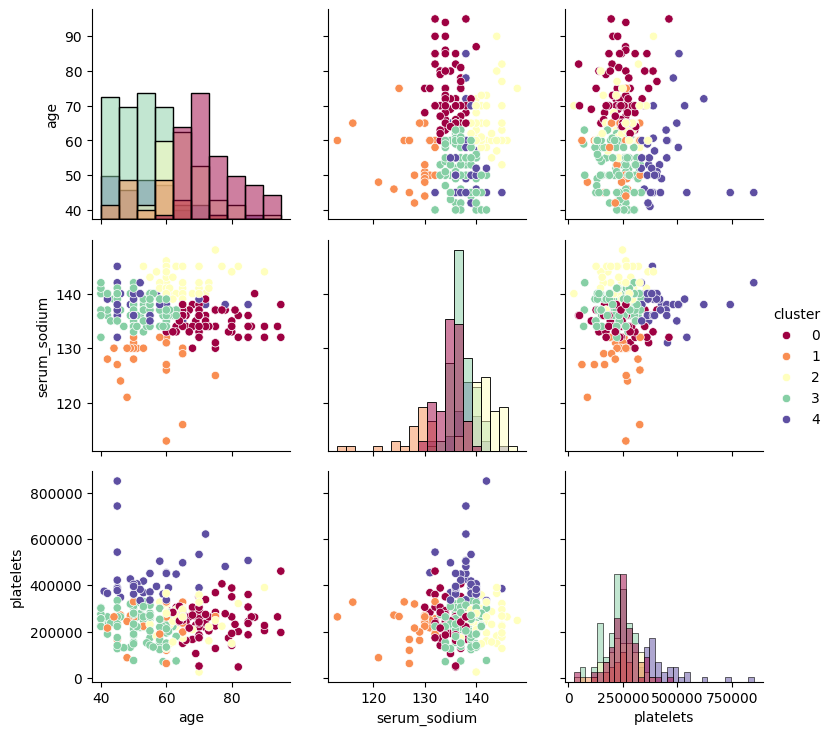

In [43]:
# numerical data exploration
g = sns.PairGrid(df[["age", "serum_sodium", "platelets", "cluster"]], hue = "cluster", palette = 'Spectral')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

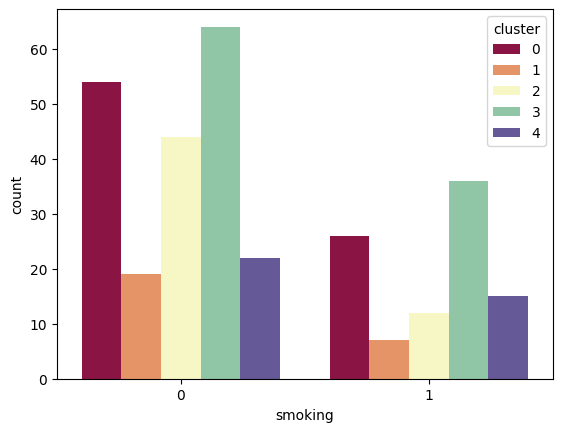

In [44]:
ax = sns.countplot(data = df, x="smoking", hue = "cluster", palette = 'Spectral' )

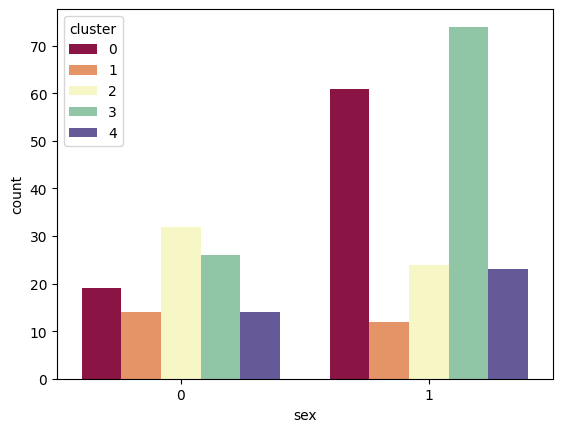

In [45]:
ax = sns.countplot(data = df, x="sex", hue = "cluster", palette = 'Spectral' )

##### Cluster Statistics

In [46]:
df[df["cluster"] == 2].describe()

,age,sex,serum_sodium,platelets,smoking,cluster
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.0
mean,65.535714,0.428571,141.553571,246056.680179,0.214286,2.0
std,7.198394,0.499350,2.522046,68026.269486,0.414039,0.0
min,53.000000,0.000000,137.000000,25100.000000,0.000000,2.0
25%,60.000000,0.000000,140.000000,200750.000000,0.000000,2.0
50%,65.000000,0.000000,141.000000,250500.000000,0.000000,2.0
75%,70.000000,1.000000,144.000000,294250.000000,0.000000,2.0
max,90.000000,1.000000,148.000000,390000.000000,1.000000,2.0
